In [1]:
import numpy as np
import scipy.sparse as sps
import scipy.linalg as spl
import scipy.sparse.linalg as spsl
from scipy import interpolate
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib
import pandas as pd
import xarray as xr
%matplotlib inline

from scipy.special import legendre,lpmv,factorial
from pyshtools.legendre import PlmSchmidt_d1

import time

from tools import *

# Functions

In [2]:
# number of time steps corresponding to 20 years
def ntsteps_to_years(n):
    L=2270e3
    pm=0.5
    eta=0.8
    return n*(L**2/eta/pm/86400/365.25 * 1e-7)

def years_to_ntsteps(y):
    L=2270e3
    pm=0.5
    eta=0.8
    return y/(L**2/(eta*pm)/86400/365.25 * 1e-7)

In [3]:
def index_of_lat(y,lat):
    return np.argmin((np.arcsin(y)*180/np.pi-lat)**2)

In [4]:
def put_at(inds, axis=-1, slc=(slice(None),)): 
    return (axis<0)*(Ellipsis,) + axis*slc + (inds,) + (-1-axis)*slc 

def fft_halfrange_sin(x,axis=-1):
    """ Returns the sine transform of an array on half range (look up 'half range fourier series'). Works the same fft, except it returns one array, 
    corresponding to the terms of the half range sine transform
    such that x_m = sum(k=1 to N-1) s_k sin(m*k*pi/N)
    """
    N=x.shape[axis]
    x2 = np.concatenate([x,-np.flip(x,axis=axis)],axis=axis)
    fft = np.fft.fft(x2,axis=axis)
    sineterms = 1j*(np.take(fft,range(1,N+1),axis=axis)-np.take(fft,range(2*N-1,N-1,-1),axis=axis))
    sineterms[put_at(N-1,axis=axis)] = 1j*np.take(fft,N,axis=axis)
    return sineterms/2/N

def fft_halfrange_cos(x,axis=-1):
    """ Returns the cosine transform of an array on half range (look up 'half range fourier series'). Works the same as np.fft.fft, except it returns one array, 
    corresponding to the terms of the half range cosine transform
    such that x_m = sum(k=0 to N-1) c_k cos(m*k*pi/N)
    Note that the length is one more than the input
    """
    N=x.shape[axis]
    x2 = np.concatenate([x,np.flip(x,axis=axis)],axis=axis)
    fft = np.fft.fft(x2,axis=axis)
    cosineterms = (np.take(fft,range(1,N+1),axis=axis)+np.take(fft,range(2*N-1,N-1,-1),axis=axis))
    cosineterms[put_at(N-1,axis=axis)] = np.take(fft,N,axis=axis)
    cosineterms=np.concatenate([np.take(fft,[0.],axis=axis),cosineterms],axis=axis)
    return cosineterms/2/N


In [5]:
def sety(ngrid,spacing):
    """Sets the grid (ngrid points between 0 and 1, without including 1)"""
    if spacing=='linear':
        return np.linspace(-1.,1.,2*ngrid+2)[1:-1][ngrid:] #exclude the -1 and 1 bounds to avoid divisions by 0
    elif spacing=='cos':
        return np.cos(np.linspace(0.,np.pi,2*ngrid+2)[1:-1][::-1][ngrid:]) #exclude the -1 and 1 bounds to avoid divisions by 0
    else:
        raise ValueError("spacing must be one of ('linear','cos')")
        
def setyA(ngrid,m,M,spacing='linear',npoints=7):
    """ Sets matrix A of the eigenvalue problem (A - C*In)x = 0"""
    y  = sety(ngrid,spacing)
    if spacing =='linear':
        D2 = secondDerivative(y)
    else:
        D2 = make_D_fornberg(y,2,npoints=npoints)
    
    L1 = -np.dot(np.diag(M*(1-y**2)/(y**2)), D2) + np.diag(M*(m**2-1)/(y**2 * (1-y**2)))

    L2 = -np.diag(m/(y**2))
    
    A=np.block([[np.zeros((ngrid,ngrid)),np.eye(ngrid)],[L1,L2]])
    A[ngrid] = np.zeros(len(A))
    A[-1] = np.zeros(len(A))
    A[ngrid,0]=   np.abs(A[ngrid+1,0])*10
    A[-1,ngrid-1]=np.abs(A[ngrid+1,0])*10
    
    return y,A

def setyA2(ngrid,m,M,spacing='linear',npoints=7):
    """ Sets matrix A of the eigenvalue problem (A - C*In)x = 0"""
    y  = sety(ngrid,spacing)
    if spacing =='linear':
        D2 = secondDerivative(y)
    else:
        D2 = make_D_fornberg(y,2,npoints=npoints)
    
    L1 = -np.dot(np.diag(M*(1-y**2)/(y**2)), D2) + np.diag(M*(m**2-1)/(y**2 * (1-y**2)))
    L2 = -np.diag(m/(y**2))
    A=np.block([[np.zeros((ngrid,ngrid)),np.eye(ngrid)],[L1,L2]])
    return y,A


def transformForcing(forcing,transformtype):
    #Focus on stratified layer
    forcing_layer = forcing[:,42:]
    
    #Define a few constants
    r_cheb = np.array(forcing_layer.radius)
    r_lin = np.linspace(r_cheb[0],r_cheb[-1],len(r_cheb))
    Nz=len(r_cheb)
    Nt=len(forcing_layer.t_step)
    
    #Here we subtract the affine part of the forcing, that doesn't contribute because what ultimately forces the wave is the second derivative (or third). This helps have smooth Fourier transforms in the subsequent decomposition
    forcing_layer_periodic = forcing_layer - forcing_layer.isel(radius_ID=-1) - (forcing_layer.radius-forcing_layer.radius[-1])*(forcing_layer.isel(radius_ID=0)-forcing_layer.isel(radius_ID=-1))/(forcing_layer.radius[0]-forcing_layer.radius[-1])
    
    #Interpolate on constant r grid & perform the half range fft
    f = interpolate.interp1d(r_cheb, np.array(forcing_layer_periodic),axis=1)
    forcing_layer_rinterp = f(r_lin)
    if transformtype == "sin":
        forcing_layer_hft=fft_halfrange_sin(np.array(forcing_layer_rinterp),axis=1)
    elif transformtype == "cos":
        forcing_layer_hft=fft_halfrange_cos(np.array(forcing_layer_rinterp),axis=1)[:,1:]
    else :
        raise ValueError("transformtype must be one of ('sin','cos')")
    
    # Perform temporal fft
    forcing_layer_hft_tft = np.fft.ifft(forcing_layer_hft,axis=0) #shape Nt,Nz,Ny #ifft because we define the temporal transform with a negative sign in the exponent
    return forcing_layer_hft_tft

In [6]:
def rhsForcing(y,C,m,M,Fr,Ftheta,Fphi,spacing='linear',npoints=7):
    ngrid=len(y)
    if spacing =='linear':
        D1 = firstDerivative(y)
    else:
        D1 = make_D_fornberg(y,1,npoints=npoints)
    
    forcingr = m**2/(M*(1-y**2)**0.5) * np.dot(D1,Fr) - ( (C*m/M + 2)*y*Fr 
                                                            + m*m/(M*(1-y**2)**(0.5)) * np.dot(D1,Fr*(1-y**2)**(0.5)) 
                                                           )
    forcingtheta = m**2/(M*(1-y**2)) * Ftheta
    forcingphi = -1j* ( (C/M + 2/m)*y*Fphi
                          + m/(M*(1-y**2)**(0.5)) * np.dot(D1,Fphi*(1-y**2)**(0.5)) 
                         )
    rhs = np.concatenate([np.zeros(ngrid),-(forcingr+forcingtheta+forcingphi)*M*(1-y**2)/y**2])  
    return rhs

def responseForcing(y,A,C,m,M,Fr,Ftheta,Fphi,spacing='linear',npoints=7):
    ngrid=len(y)
    rhs = rhsForcing(y,C,m,M,Fr,Ftheta,Fphi,spacing,npoints)
    A = sps.csc_matrix(A)
    return rhs,spsl.spsolve(A-C*sps.eye(2*ngrid),rhs)[:ngrid]/(1-y**2)


In [7]:
heat_advect_y = xr.open_dataset("data/data808/heat_advect_y_300_cos.nc")
heat_advect_y=heat_advect_y.heat_advect_real

In [8]:
temperature_y = xr.open_dataset("data/data808/temperature_y_300_cos.nc")
temperature_y=temperature_y.temperature_real

In [35]:
lorentz_y = xr.open_dataset("data/data808/Lorentz_force_y_300_cos.nc")
lorentz_theta_y = lorentz_y.Lorentz_force_theta_real+1j*lorentz_y.Lorentz_force_theta_imag
lorentz_phi_y = lorentz_y.Lorentz_force_phi_real+1j*lorentz_y.Lorentz_force_phi_imag
lorentz_r_y = lorentz_y.Lorentz_force_r_real+1j*lorentz_y.Lorentz_force_r_imag

In [10]:
m=3
sectoyear = 365.25 * 24 * 60 * 60

# use realistic values
E = 1e-15
Pm = 4.7e-7
Rastar = 8e-5   # From "stochastic generation" (earth-like value)
Omega = 2*np.pi/86400

Hprime=0.062 #Nondimensional layer thickness #0.11 to match simulation
kprime = np.pi/Hprime
Nprime = 0.583 #0.14/E From "stochastic generation"
Brprime = 3e-5 #np.sqrt(float(layered_s.M_ene_pol.sel(radial_id=310).mean())*2)
omegaprime = 2*np.pi / (-20*sectoyear) / Omega

C0 = 2/0.65**2*kprime**2/Nprime**2
C = C0*omegaprime

chi = 1 +1j*kprime**2/omegaprime*E/Pm
M = 1/(0.65**2)*Brprime**2*kprime**4/(chi*Nprime**2)

fixedparams=(m,E,Pm,Rastar,Omega,Hprime,Nprime,Brprime)

# Eigen basis

Here, we are solving for the eigenvalues $\omega_k$ and eigenfunctions $x_k$ (as well as adjoint eigenfunctions) of our eigenvalue problem $$(A - C I_n)x=0$$

We will use the non-viscous nondimensionalization throughout this notebook.
Also y is restricted between 0 and 1, to avoid symmetry issues. 

In [13]:
(Brprime * kprime**3)/ (0.65**2*chi*Nprime**2)

(27.135693224947065+1.0828782966142867j)

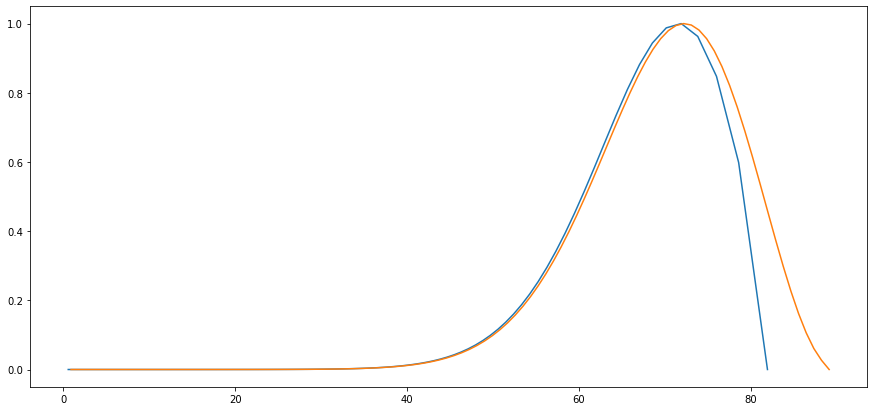

In [554]:
_,ax=plt.subplots(1,1,figsize=(15,7))


ngrid=100
y,A=setyA(ngrid,m,M,'linear')
Cdiag,bysec = modesy(A,C);by = bysec[:ngrid]/(1-y**2);amp = np.max(np.abs(np.real(by)))
ax.plot(np.arcsin(y)*180.0/np.pi,np.abs(np.real(by))/amp)

ngrid=100
y,A=setyA(ngrid,m,M,'cos')
Cdiag,bysec = modesy(A,C);by = bysec[:ngrid]/(1-y**2);amp = np.max(np.abs(np.real(by)))
ax.plot(np.arcsin(y)*180.0/np.pi,np.abs(np.real(by))/amp)


In [136]:
np.real(2*np.pi*C0/(w*sectoyear*Omega))[np.abs(np.real(2*np.pi*C0/(w*sectoyear*Omega)))>10]

array([-10.25998689, -11.05888793, -11.99887859, -13.12229823,
       -14.4908189 , -16.19820428, -18.39498441, -21.34079946,
       362.46099046, 180.32330857, 110.76678031,  76.65790077,
        57.23949522,  45.02431203,  36.77155968,  30.8895162 ,
        26.51979465,  23.16482071,  20.51908991,  18.38601429,
        16.63406169,  15.17228356,  13.93599994,  12.87808155,
        11.96345244,  11.16551678,  10.46377342])

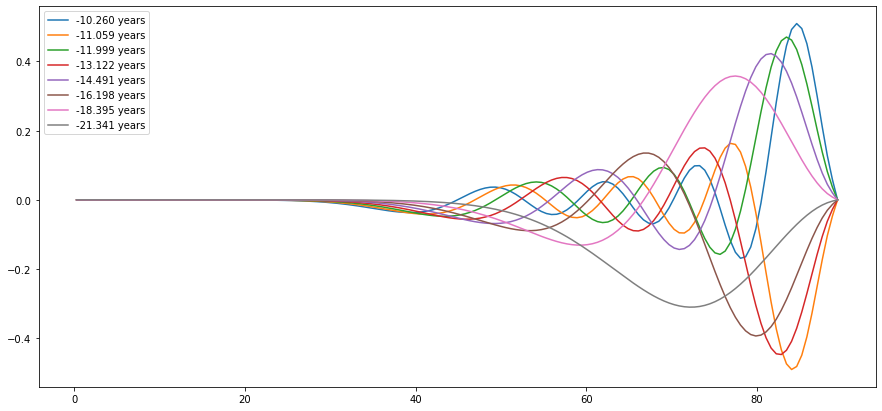

In [137]:
_,ax=plt.subplots(1,1,figsize=(15,7))

ngrid=150
y,A=setyA(ngrid,m,M,'cos')
w,v=spl.eig(A)
w,v = spl.eig(A)
v=v[:,np.argsort(np.real(w))]
w=w[np.argsort(np.real(w))]
v=v[:ngrid]/(1-y[:,None]**2)
n=140
for j in range(142,150):
    ax.plot(np.arcsin(y)*180.0/np.pi,np.real(v[:,j]),label="{:<3.3f} years".format(np.real(2*np.pi*C0/(w[j]*sectoyear*Omega))))

plt.legend()

**Adapting damping**

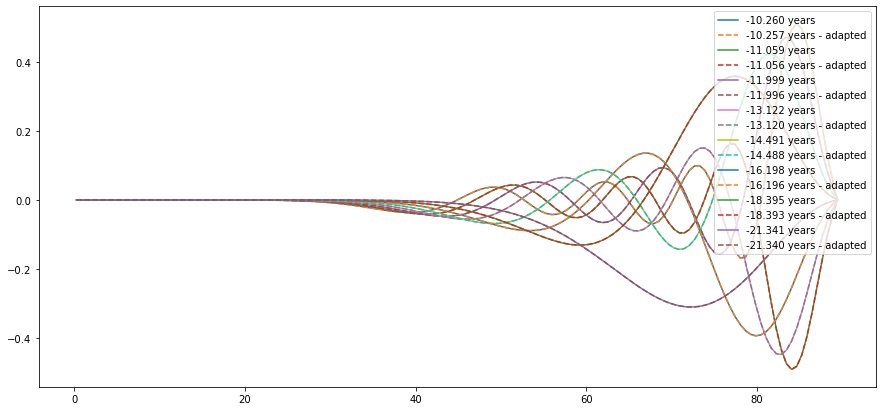

In [78]:
_,ax=plt.subplots(1,1,figsize=(15,7))

ngrid=150
y,A=setyA(ngrid,m,M,'cos')
w,v=spl.eig(A)
v=v[:,np.argsort(np.real(w))]
w=w[np.argsort(np.real(w))]
v=v[:ngrid]/(1-y[:,None]**2)
n=140
for j in range(142,150):
    mode_freq=w[j]/C0
    chi_adapt = 1 +1j*kprime**2/mode_freq*E/Pm
    M_adapt = 1/(0.65**2)*Brprime**2*kprime**4/(chi_adapt*Nprime**2)
    
    _,A_adapt=setyA(ngrid,m,M_adapt,'cos')
    w_adapt,v_adapt=spl.eig(A_adapt)
    v_adapt=v_adapt[:,np.argsort(np.real(w_adapt))]
    w_adapt=w_adapt[np.argsort(np.real(w_adapt))]
    v_adapt=v_adapt[:ngrid]/(1-y[:,None]**2)
    
    ax.plot(np.arcsin(y)*180.0/np.pi,np.real(v[:,j]),label="{:<3.3f} years".format(np.real(2*np.pi*C0/(w[j]*sectoyear*Omega))))
    ax.plot(np.arcsin(y)*180.0/np.pi,np.real(v_adapt[:,j]),linestyle='--',label="{:<3.3f} years - adapted".format(np.real(2*np.pi*C0/(w_adapt[j]*sectoyear*Omega))))
    #ax.plot(np.arcsin(y)*180.0/np.pi,np.real(v_adapt[:,j])-np.real(v[:,j]),linestyle='--',label="{:<3.3f} years - adapted".format(np.real(2*np.pi*C0/(w_adapt[j]*sectoyear*Omega))))

plt.legend()

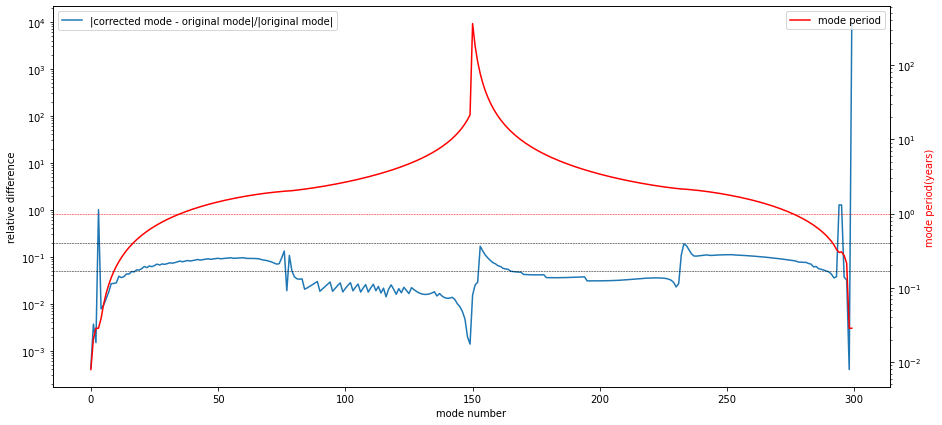

In [114]:
_,ax=plt.subplots(1,1,figsize=(15,7))

ngrid=150
y,A=setyA(ngrid,m,M,'cos')
w,v=spl.eig(A)
v=v[:,np.argsort(np.real(w))]
w=w[np.argsort(np.real(w))]
v=v[:ngrid]/(1-y[:,None]**2)

#deviations=[]
#for j in range(300):
#    mode_freq=w[j]/C0
#    chi_adapt = 1 +1j*kprime**2/mode_freq*E/Pm
#    M_adapt = 1/(0.65**2)*Brprime**2*kprime**4/(chi_adapt*Nprime**2)
#    
#    _,A_adapt=setyA(ngrid,m,M_adapt,'cos')
#    w_adapt,v_adapt=spl.eig(A_adapt)
#    v_adapt=v_adapt[:,np.argsort(np.real(w_adapt))]
#    w_adapt=w_adapt[np.argsort(np.real(w_adapt))]
#    v_adapt=v_adapt[:ngrid]/(1-y[:,None]**2)
#
#    deviations.append(spl.norm(v[:,j]-v_adapt[:,j])/spl.norm(v[:,j]))
ax.plot(range(300),deviations,label="|corrected mode - original mode|/|original mode|")
ax.axhline(0.2,color='k',linestyle='--',linewidth=0.5)
ax.axhline(0.05,color='k',linestyle='--',linewidth=0.5)
ax.legend()
ax.set_yscale('log')
ax.set_ylabel('relative difference')
ax.set_xlabel('mode number')

ax2=ax.twinx()
ax2.plot(range(300),np.abs(np.real(2*np.pi*C0/(w*sectoyear*Omega))),color='r',label='mode period')
ax2.axhline(1,color='r',linestyle='--',linewidth=0.5)
ax2.set_yscale('log')
ax2.set_ylabel('mode period(years)', color='r')
ax2.legend()

[Text(0, 0, '0°N'),
 Text(10, 0, '10°N'),
 Text(20, 0, '20°N'),
 Text(30, 0, '30°N'),
 Text(40, 0, '40°N'),
 Text(50, 0, '50°N'),
 Text(60, 0, '60°N'),
 Text(70, 0, '70°N'),
 Text(80, 0, '80°N'),
 Text(90, 0, '90°N')]

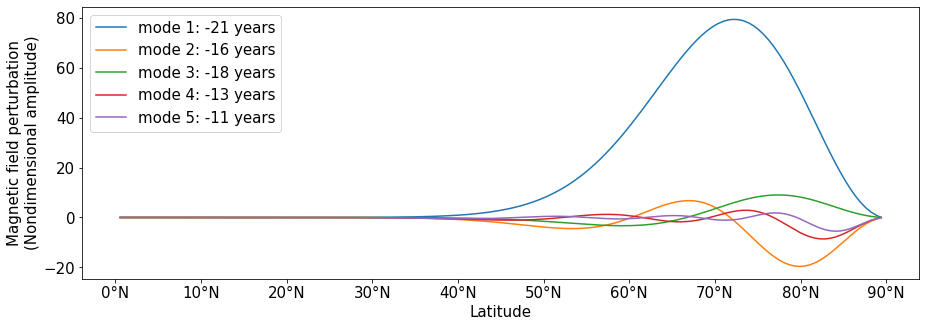

In [727]:
plt.rcParams.update({'font.size':15})
ngrid=150
y,A=setyA(ngrid,m,M,'cos')
forcing = y**0

wi,zi,xi=spl.eig(A,left=True)
#Normalize left eigenvectors so that zj^H * xi = delta_ij
zi = zi/np.diagonal(np.dot(zi.transpose().conj(),xi))[None,:].conj()
#Compute forced wave from theory
c_forcing = np.dot(zi.transpose().conj(),rhs)


C1 = C0*(2*np.pi / (-20*sectoyear) / Omega)
waves2 = ((c_forcing/(wi-C1))[None,:]* xi)[:ngrid]/(1-y**2)[:,None]

waves2_power_idx=(waves2**2).sum(axis=0).argsort()[-5:][::-1]

_,ax=plt.subplots(1,1,figsize=(15,5))
for j,i in enumerate(waves2_power_idx):
    ax.plot(np.arcsin(y)*180.0/np.pi,np.real(waves2[:,i]),label="mode {:d}: {:<3.0f} years".format(j+1,np.real(2*np.pi*C0/(wi[i]*sectoyear*Omega))))#"mode %i: %4i years"%(j,np.real(2*np.pi*C0/(wi[i]*sectoyear*Omega))))
ax.legend()#fontsize=13)
ax.set_ylabel("Magnetic field perturbation\n(Nondimensional amplitude)")
ax.set_xlabel("Latitude")
ticks=np.arange(0,91,10)
ax.set_xticks(ticks)
ax.set_xticklabels(['%i°N'%lat for lat in ticks])




# Example forcing, previous & new solution

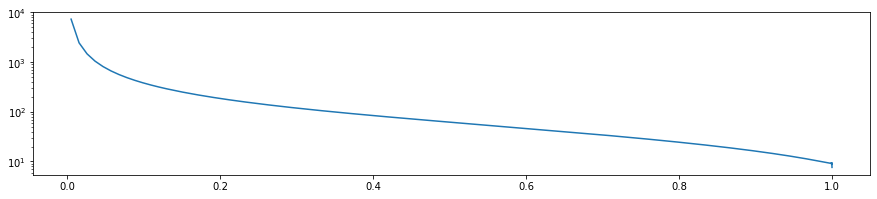

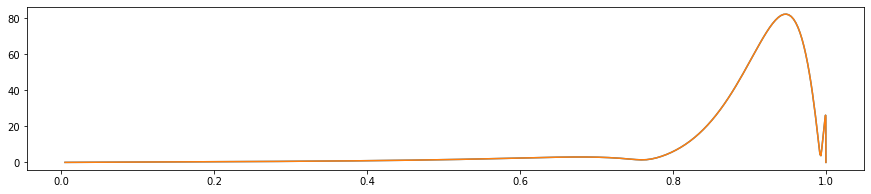

In [215]:
ngrid=150
y,A=setyA(ngrid,m,M,'cos')
forcing = y**0
#forcing = 1/(1-y**2)**(0.5)

_,wave1 = responseForcing(y,A,C,m,M,forcing,0.,0.,spacing='cos',npoints=7)

_,ax=plt.subplots(1,1,figsize=(15,3))
ax.plot(y,np.abs(rhs[ngrid:]))
ax.set_yscale('log')

wi,zi,xi=spl.eig(A,left=True)
#Normalize left eigenvectors so that zj^H * xi = delta_ij
zi = zi/np.diagonal(np.dot(zi.transpose().conj(),xi))[None,:].conj()
#Compute forced wave from theory
rhs=rhsForcing(y,C,m,M,forcing,0.,0.,spacing='cos',npoints=7)
c_forcing = np.dot(zi.transpose().conj(),rhs)
wave2 = ((c_forcing/(wi-C))[None,:]* xi).sum(axis=1)[:ngrid]/(1-y**2)

_,ax=plt.subplots(1,1,figsize=(15,3))
ax.plot(y,np.abs(wave1))#np.arcsin(y)*180.0/np.pi
ax.plot(y,np.abs(wave2))
#ax.set_yscale('log')
#ax.set_ylim(0,20e3)

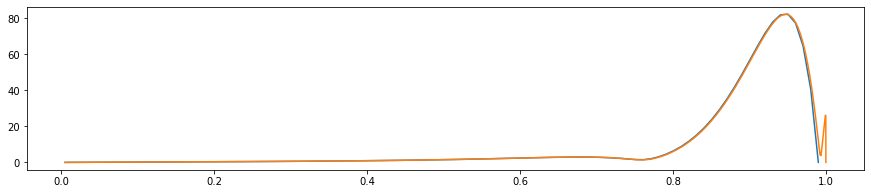

In [216]:
_,ax=plt.subplots(1,1,figsize=(15,3))

ngrid=100
y,A=setyA(ngrid,m,M,'linear')
forcing = y**0
_,wave = responseForcing(y,A,C,m,M,forcing,0.,0.,spacing='linear',npoints=7)
ax.plot(y,np.abs(wave))

ngrid=150
y,A=setyA(ngrid,m,M,'cos')
forcing = y**0

_,wave = responseForcing(y,A,C,m,M,forcing,0.,0.,spacing='cos',npoints=7)
ax.plot(y,np.abs(wave))



# Heat advection source

## Comparing $v\cdot\nabla T$ with $-\partial_t (\delta T)$

### Fourier transform approach

It doesn't work at all. I don't really have an explanation for this, except maybe that the fourier transform isn't precise on such a coarse time discretization... 

In [192]:
heat_advect_y_tfourier=np.fft.ifft(xr.open_dataarray("data/data808/heat_advect.nc"),axis=0)

In [193]:
temperature_tfourier = np.fft.ifft(xr.open_dataarray("data/data808/temperature.nc"),axis=0)

In [194]:
heat_advect_y_tfourier=np.concatenate([heat_advect_y_tfourier[-399:],heat_advect_y_tfourier[:401]])
temperature_tfourier=np.concatenate([temperature_tfourier[-399:],temperature_tfourier[:401]])

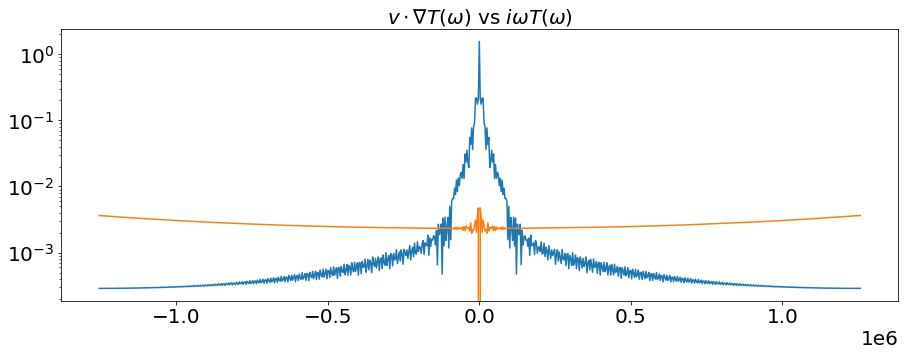

In [214]:
deltat_calypsounits = 1e-7
omega_calypsounits=2*np.pi*np.array(list(np.arange(-399,401,1)/(800*25*deltat_calypsounits)))

_,ax=plt.subplots(1,1,figsize=(15,5))
ax.set_title(r"$v\cdot\nabla T (\omega)$ vs $i\omega T(\omega)$",fontsize=20)
ax.plot(omega_calypsounits,np.abs(heat_advect_y_tfourier[:,80,0,0]))
ax.plot(omega_calypsounits,np.abs(i*omega_calypsounits*temperature_tfourier[:,80,0,0])/500)
#ax.set_xlim(-5e5,5e5)
ax.set_yscale('log')

### Finite difference approach

In [119]:
heat_advect=xr.open_dataarray("data/data808/heat_advect.nc")

In [120]:
temperature = xr.open_dataarray("data/data808/temperature.nc")

Text(0.5, 0.98, 'Radius = 1.476')

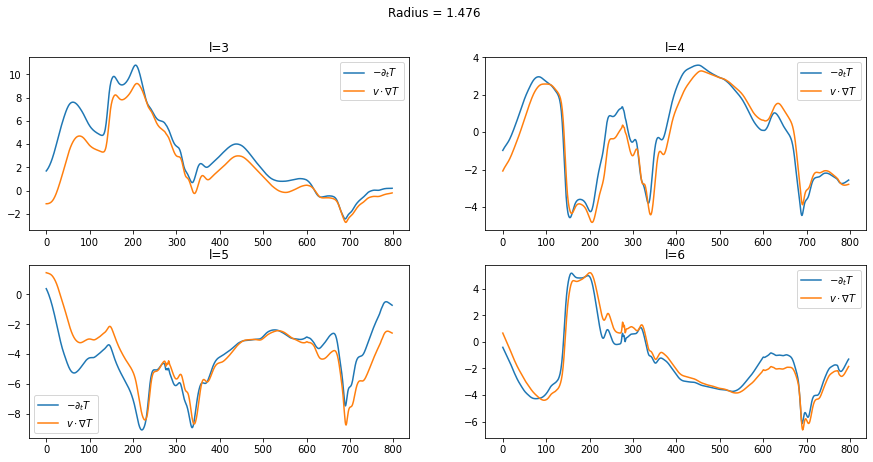

In [140]:
fig,axs=plt.subplots(2,2,figsize=(15,7))
r=42
for i,ax in enumerate(axs.reshape(-1)):
    #i*=10
    ax.plot(-(np.array(temperature[2:,r,i,0])-np.array(temperature[:-2,r,i,0]))/50e-7, label=r"$-\partial_t T$")
    ax.plot(heat_advect[1:-1,r,i,0], label=r"$v\cdot\nabla T$")
    ax.legend()
    ax.set_title("l=%i"%temperature.degree[i])
fig.suptitle("Radius = %.3f"%temperature.radius[r])

Text(0.5, 0.98, 'Radius = 1.521')

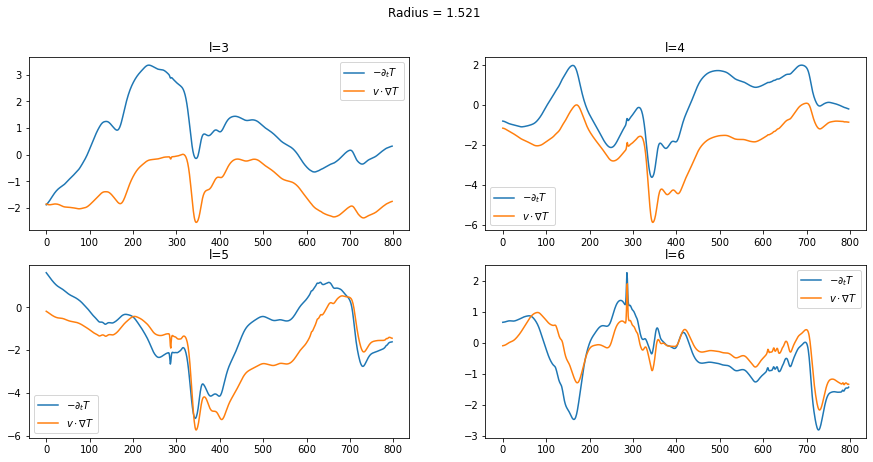

In [143]:
fig,axs=plt.subplots(2,2,figsize=(15,7))
r=70
for i,ax in enumerate(axs.reshape(-1)):
    #i*=10
    ax.plot(-(np.array(temperature[2:,r,i,0])-np.array(temperature[:-2,r,i,0]))/50e-7, label=r"$-\partial_t T$")
    ax.plot(heat_advect[1:-1,r,i,0], label=r"$v\cdot\nabla T$")
    ax.legend()
    ax.set_title("l=%i"%temperature.degree[i])
fig.suptitle("Radius = %.3f"%temperature.radius[r])

## With $v\cdot\nabla T$

In [48]:
# Fourier transform the forcing
y,_=setyA(150,m,M,'cos')
heat_advect_y_layer_tilda_300=transformForcing(heat_advect_y,'sin')

In [49]:
# Average NH and SH (i.e. fold it)
heat_advect_y_layer_tilda_fold=0.5*(heat_advect_y_layer_tilda_300[:,:,150:]+heat_advect_y_layer_tilda_300[:,:,149::-1])

In [50]:
# Convert magnitude to diffusion-free scales
heat_advect_y_layer_tilda_fold *= E

### Response to a fixed frequency

In [54]:
def responseBuoyancy(ngrid,period,j,fixedparams,heat_advect_tilda,spacing='linear',npoints=7):
    """For a given m,j(radial wavenumber), and wave period, return the latitudinal shape of the wave response to forcing by buoyancy"""
    m,E,Pm,Rastar,Omega,Hprime,Nprime,Brprime=fixedparams
    sectoyear = 365.25 * 24 * 60 * 60
    
    kprime = np.pi*j/Hprime
    omegaprime = 2*np.pi / (period*sectoyear) / Omega
    
    C0 = 2/0.65**2*kprime**2/Nprime**2
    C = C0*omegaprime
    
    chi = 1 +1j*kprime**2/omegaprime*E/Pm
    M = 1/(0.65**2)*Brprime**2*kprime**4/(chi*Nprime**2)

    G_r = (Rastar * Brprime * kprime**2)/ (0.65*1j*omegaprime*chi*Nprime**2)
    
    #Find the index corresponding to the desired frequency
    if period >0:
        freq_idx=int(800*25/years_to_ntsteps(period))
    else:
        freq_idx=800-int(800*25/years_to_ntsteps(-period))
        
    Fr = G_r*heat_advect_tilda[freq_idx,j-1,:]
    
    print(G_r)
    print(np.abs(heat_advect_tilda[freq_idx,j-1,:]).mean())
    print(np.abs(Fr).mean())
    
    y,A =setyA(ngrid,m,M,'cos')
    rhs,by= responseForcing(y,A,C,m,M,Fr,0.,0.,spacing=spacing,npoints=npoints)
    
    return Fr,rhs[ngrid:],by

In [59]:
_=responseBuoyancy(150,-20,3,fixedparams,heat_advect_y_layer_tilda_fold,spacing='cos')

(-0.5833514471359036+1.624235660882418j)
1.229480199314799e-16
2.121856431213071e-16


Text(0.5, 1.0, 'rhs')

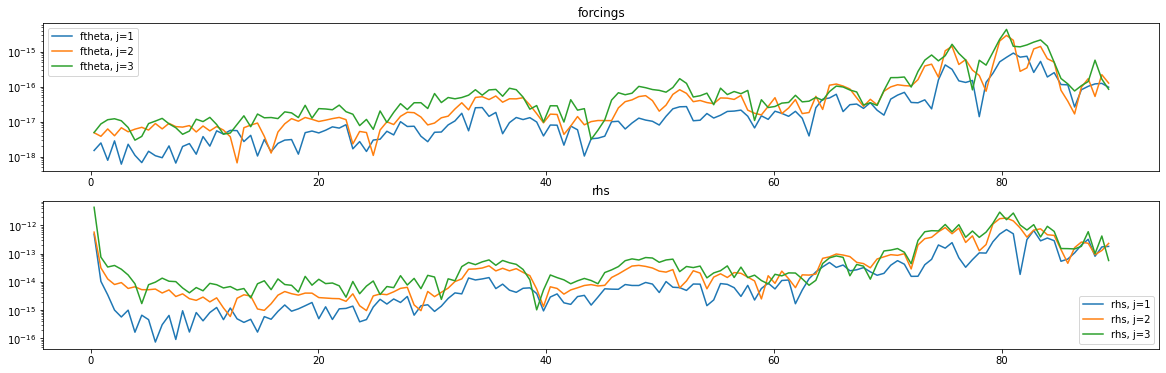

In [53]:
_,ax=plt.subplots(2,1,figsize=(20,6))
fixedparams=(m,E,Pm,Rastar,Omega,Hprime,Nprime,Brprime)

cutoff=0
for j in range(1,4):
    fr,rhs,by=responseBuoyancy(150,-20,j,fixedparams,heat_advect_y_layer_tilda_fold,spacing='cos')
    ax[0].plot(np.arcsin(y)*180.0/np.pi,np.abs(fr),label='ftheta, j=%i'%j)
    ax[1].plot(np.arcsin(y)*180.0/np.pi,np.abs(rhs),label='rhs, j=%i'%j)

for i,a in enumerate(ax):
    if  i < 2:
        a.set_yscale('log')
    a.legend()
ax[0].set_title('forcings')
ax[1].set_title('rhs')


Text(0.5, 1.0, 'wave responses, linear scale')

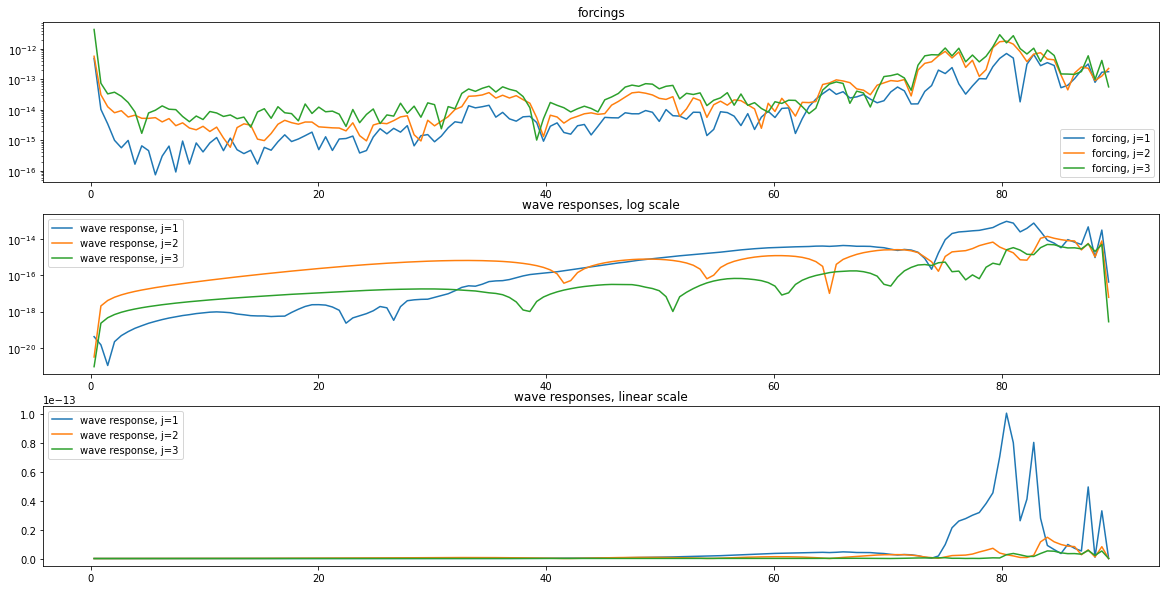

In [226]:
_,ax=plt.subplots(3,1,figsize=(20,10))
fixedparams=(m,E,Pm,Rastar,Omega,Hprime,Nprime,Brprime)

cutoff=0
for j in range(1,4):
    fr,rhs,by=responseBuoyancy(150,-20,j,fixedparams,heat_advect_y_layer_tilda_fold,spacing='cos')
    ax[0].plot(np.arcsin(y)*180.0/np.pi,np.abs(fr),label='fr, j=%i'%j)
    #ax[0].plot(np.arcsin(y)*180.0/np.pi,np.abs(rhs),label='forcing, j=%i'%j)
    ax[1].plot(np.arcsin(y[cutoff:])*180.0/np.pi,np.abs(np.real(by))[cutoff:],label='wave response, j=%i'%j)
    ax[2].plot(np.arcsin(y[cutoff:])*180.0/np.pi,np.abs(np.real(by))[cutoff:],label='wave response, j=%i'%j)

for i,a in enumerate(ax):
    if  i < 2:
        a.set_yscale('log')
    a.legend()
ax[0].set_title('forcings')
ax[1].set_title('wave responses, log scale')
ax[2].set_title('wave responses, linear scale')

CPU times: user 967 ms, sys: 131 ms, total: 1.1 s
Wall time: 756 ms


Text(0.5, 1.0, 'wave responses, all radial contributions')

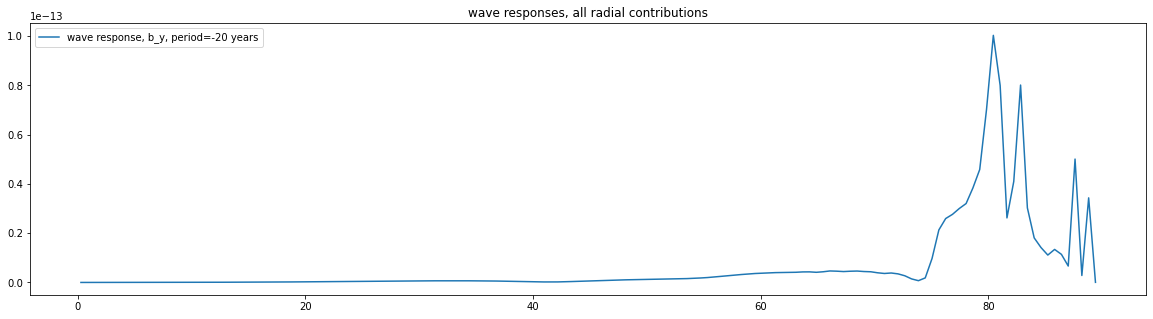

In [219]:
%%time
_,ax=plt.subplots(1,1,figsize=(20,5))
period=-20
by_all=[]
for j in range(1,58):
    _,_,by=responseBuoyancy(150,period,j,fixedparams,heat_advect_y_layer_tilda_fold,spacing='cos')
    by_all.append(by)
    
by_all=np.array(by_all)
by_rms=np.sqrt((np.real(by_all)**2).sum(axis=0))#*np.sqrt(1e4*4*np.pi*1e-7)*Omega*L*(2*np.pi/20)**2*1e6

ax.plot(np.arcsin(y)*180.0/np.pi,by_rms,label='wave response, b_y, period=%i years'%period)
    
#ax.set_yscale('log')
ax.legend()
ax.set_title('wave responses, all radial contributions')

We have obtained, for a given mode $m,k,\omega$, the wave solution as a zonal magnetic perturbation $\tilde b_y(y)$. In order to relate this to a velocity perturbation, we integrate the induction equation, which in the Fourier space reads $$\partial_r(B_r \tilde v_y) = -i\omega\chi \tilde b_y$$
If the velocity perturbation is zero at the base of the layer (or below a small skin depth), then an order of magnitude for $\tilde v_y$ is $$\tilde v_y \simeq -i H\omega\chi \tilde b_y /B_r$$
If all these quantities are nondimensional, then we convert back to dimensional terms by multipliying by $\Omega L$

In [230]:
byss_obs = 1e-6 #T/yr^2
by_obs = byss_obs/((2*np.pi/20)**2) # in T
vy_obs = 140 * 2*np.pi/20 *by_obs/5e-4 # in km/year, order of magnitude
print("Velocity perturbation in observations (km/yr) : %.3f"%vy_obs )
print("Magnetic field perturbation in observations (nondimensional) : %.3e"%(by_obs/(np.sqrt(1e4*4*np.pi*1e-7)*Omega*L)) )


Velocity perturbation in observations (km/yr) : 0.891
Magnetic field perturbation in observations (nondimensional) : 5.495e-07


In [225]:
L = 3.48e6*0.65
Omega = 2*np.pi/86400
velocityscale = Omega*L

b_to_v_factor = -1j*omegaprime*chi*Hprime/Brprime

vy_all = velocityscale*b_to_v_factor*by_all # in m/s
vy_rms=np.sqrt((np.real(vy_all)**2).sum(axis=0))

Text(0.5, 1.0, 'wave velocity perturbation rms, all radial contributions')

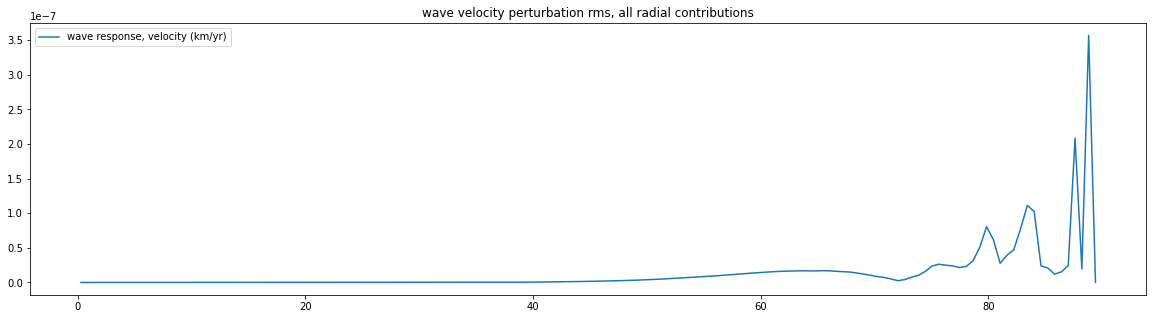

In [88]:
_,ax=plt.subplots(1,1,figsize=(20,5))
ax.plot(np.arcsin(y)*180.0/np.pi,vy_rms/1e3*sectoyear,label='wave response, velocity (km/yr)')
ax.legend()
ax.set_title('wave velocity perturbation rms, all radial contributions')

### Power spectrum on eigenmodes

Here, we pick the eigenmodes of the unforced problem and express the power distribution of the response to a forcing projected on a specific mode.
e.g., let's say the modes of our problem $Ax - \omega x = 0$ are $(x_k)_{1\leq k \leq N}$. We pick one $k$, identified by its period (related to its eigenvalue $\omega_k$ by $T_k = 2\pi/\omega_k$). We write the forcing (or rather its partial fourier transform) as $F(\omega,y)$, and, if we denote $x(\omega,y)$ the response to the forced problem $Ax(\omega,y) - \omega x(\omega,y) = F(\omega,y)$. We plot below, for various $k$, the function $\omega \mapsto |x_k(y)^Tx(\omega,y)|^2$.

One caveat in all this is that $A$ itself depends on $\omega$, through the damping factor $\chi$. We will ignore this dependence by setting $\chi$ as for $\omega = 2\pi/\text{20 years}$ 

In [86]:
def spectrumBuoyancy(ngrid,j,eigenmode_number,fixedparams,heat_advect_tilda,spacing='linear',npoints=7):
    """For a given m,j(radial wavenumber), return the power spectrum of the wave response to forcing by buoyancy, projected on a specific eigenmode"""
    
    # Set up prefactor
    m,E,Pm,Rastar,Omega,Hprime,Nprime,Brprime=fixedparams
    sectoyear = 365.25 * 24 * 60 * 60
    
    kprime = np.pi*j/Hprime
    omegaprime = 2*np.pi / ((-20)*sectoyear) / Omega #assumed period for damping
    
    C0 = 2/0.65**2*kprime**2/Nprime**2
    C = C0*omegaprime
    
    chi = 1 +1j*kprime**2/omegaprime*E/Pm
    M = 1/(0.65**2)*Brprime**2*kprime**4/(chi*Nprime**2)
    
    # Compute matrix and eigendecomposition
    y,A=setyA(ngrid,m,M,spacing)
    wi,zi,xi=spl.eig(A,left=True)
    #Normalize left eigenvectors so that zj^H * xi = delta_ij
    zi = zi/np.diagonal(np.dot(zi.transpose().conj(),xi))[None,:].conj()
    #Sort eigenvectors by increasing period
    zi=zi[:,np.argsort(np.real(1/wi))]
    wi=wi[np.argsort(np.real(1/wi))]
    
    eigenmode_period = np.real(2*np.pi*C0/(wi[eigenmode_number]*sectoyear*Omega))
    #print("Eigenmode period=%.1f years; frequency=%.3f cycles/year"%(eigenmode_period,1/eigenmode_period))
    
    frequencies=np.fft.fftfreq(len(heat_advect_tilda),ntsteps_to_years(25))[1:]
    Cs=C0*(2*np.pi*frequencies/sectoyear / Omega)
    #Compute component of forced wave on first eigenvector
    power_spectrum=[]
    for i,C1 in enumerate(Cs):
        #C1omegaprime = C1/C0
        #C1chi = 1 +1j*kprime**2/C1omegaprime*E/Pm
        #G_r = (Rastar * Brprime * kprime**2)/ (0.65*1j*C1omegaprime*C1chi*Nprime**2)
        G_r = (Rastar * Brprime * kprime**2)/ (0.65*1j*omegaprime*chi*Nprime**2)
        Fr = G_r*heat_advect_tilda[i,j-1,:]
        rhs=rhsForcing(y,C1,m,M,Fr,0.,0.,spacing,npoints)
        c_forcing = np.dot(zi[:,eigenmode_number].conj(),rhs)
        power=np.abs((c_forcing/(wi[eigenmode_number]-C1)))**2
        power_spectrum.append(power)
    power_spectrum=np.array(power_spectrum)[np.argsort(frequencies)]
    return np.sort(frequencies),power_spectrum,eigenmode_period

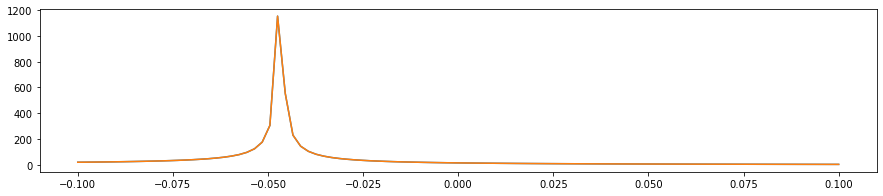

In [167]:
# 20-year mode

ngrid=150
y,A=setyA(ngrid,m,M,'cos')

wi,zi,xi=spl.eig(A,left=True)
#Normalize left eigenvectors so that zj^H * xi = delta_ij
zi = zi/np.diagonal(np.dot(zi.transpose().conj(),xi))[None,:].conj()

frequencies=np.linspace(0.1,-0.1,100)
Cs=C0*(2*np.pi*frequencies/sectoyear / Omega)
#Sort eigenvectors by increasing period
zi=zi[:,np.argsort(np.real(1/wi))]
wi=wi[np.argsort(np.real(1/wi))]

#Compute component of forced wave on first eigenvector
power_spectrum=[]
for C1 in Cs:
    rhs=rhsForcing(y,C1,m,M,y**0,spacing='cos',npoints=7)
    c_forcing = np.dot(zi[:,0].conj(),rhs)
    power=np.abs((c_forcing/(wi[0]-C1)))
    power_spectrum.append(power)

_,ax=plt.subplots(1,1,figsize=(15,3))
ax.plot(frequencies,power_spectrum)


01234

Text(0.5, 0, 'Frequencies (cycles/year)')

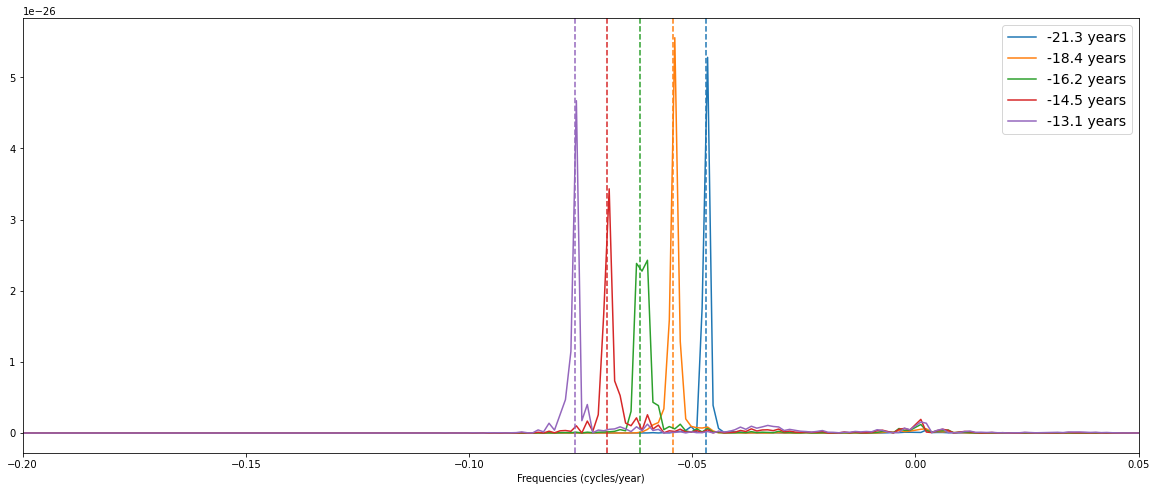

In [87]:
_,ax=plt.subplots(1,1,figsize=(20,8))
colors=plt.rcParams['axes.prop_cycle'].by_key()['color']
for i in range(5):
    print(i,end='')
    frequencies,power_spectrum,period=spectrumBuoyancy(150,1,i,fixedparams,heat_advect_y_layer_tilda_fold,spacing='cos')
    ax.plot(frequencies,power_spectrum,color=colors[i%10],label="%.1f years"%period)
    ax.axvline(1/period,color=colors[i%10],linestyle='--')
    
ax.set_xlim(-0.2,0.05) 
ax.legend(fontsize=14)
ax.set_xlabel('Frequencies (cycles/year)')

## With T

In [48]:
from scipy.ndimage.filters import uniform_filter1d,gaussian_filter1d

In [11]:
# Fourier transform the forcing
y,_=setyA(150,m,M,'cos')
temperature_y_layer_tilda_300=transformForcing(temperature_y,'sin')
#temperature_y_layer_tilda_300_prime=transformForcing(temperature_y[51:-51]-uniform_filter1d(temperature_y, size=100,axis=0,mode='nearest')[51:-51],'sin')

In [12]:
# Average NH and SH (i.e. fold it)
temperature_y_layer_tilda_fold=0.5*(temperature_y_layer_tilda_300[:,:,150:]+temperature_y_layer_tilda_300[:,:,149::-1])
#temperature_y_layer_tilda_fold_prime=0.5*(temperature_y_layer_tilda_300_prime[:,:,150:]+temperature_y_layer_tilda_300_prime[:,:,149::-1])

In [13]:
# Convert magnitude to diffusion-free scales
temperature_y_layer_tilda_fold *= 1

### Response to a fixed frequency

In [14]:
def responseBuoyancyT(ngrid,period,j,fixedparams,temperature_tilda,spacing='linear',npoints=7):
    """For a given m,j(radial wavenumber), and wave period, return the latitudinal shape of the wave response to forcing by buoyancy"""
    m,E,Pm,Rastar,Omega,Hprime,Nprime,Brprime=fixedparams
    sectoyear = 365.25 * 24 * 60 * 60
    
    kprime = np.pi*j/Hprime
    omegaprime = 2*np.pi / (period*sectoyear) / Omega
    
    C0 = 2/0.65**2*kprime**2/Nprime**2
    C = C0*omegaprime
    
    chi = 1 +1j*kprime**2/omegaprime*E/Pm
    M = 1/(0.65**2)*Brprime**2*kprime**4/(chi*Nprime**2)

    G_r = (Rastar * Brprime * kprime**2)/ (0.65*chi*Nprime**2)
    
    #Find the index corresponding to the desired frequency
    if period >0:
        freq_idx=int(800*25/years_to_ntsteps(period))
    else:
        freq_idx=800-int(800*25/years_to_ntsteps(-period))
        
    Fr = G_r*temperature_tilda[freq_idx,j-1,:]
    
    y,A =setyA(ngrid,m,M,'cos')
    rhs,by= responseForcing(y,A,C,m,M,Fr,0.,0.,spacing=spacing,npoints=npoints)
    
    return Fr,rhs[ngrid:],by

Text(0.5, 1.0, 'wave responses, linear scale')

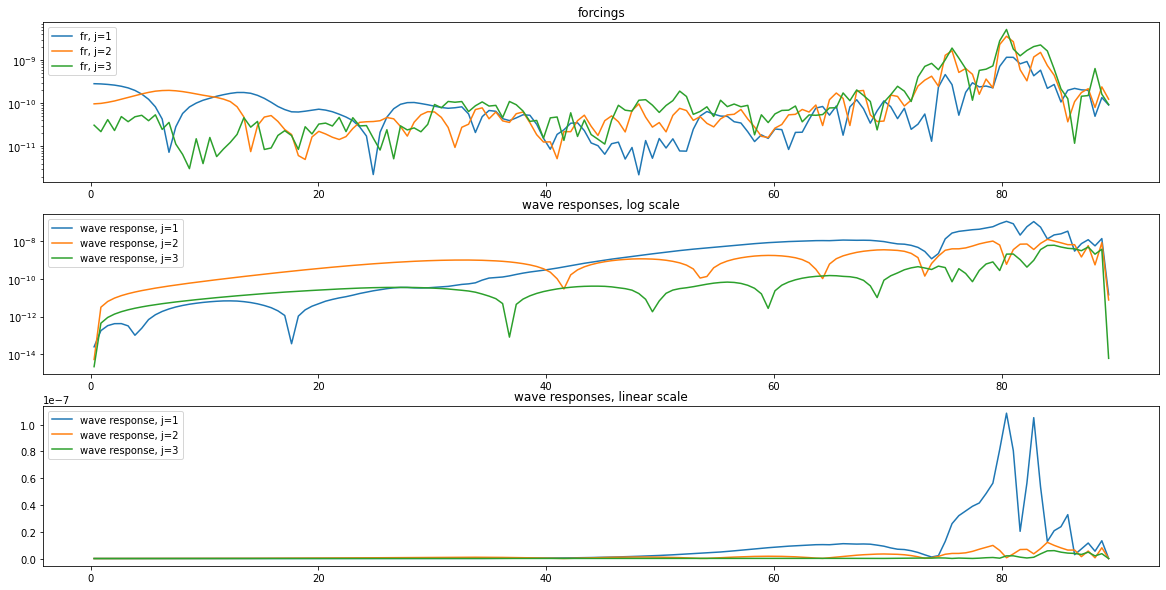

In [15]:
_,ax=plt.subplots(3,1,figsize=(20,10))
fixedparams=(m,E,Pm,Rastar,Omega,Hprime,Nprime,Brprime)

cutoff=0
for j in range(1,4):
    fr,rhs,by=responseBuoyancyT(150,-20,j,fixedparams,temperature_y_layer_tilda_fold,spacing='cos')
    ax[0].plot(np.arcsin(y)*180.0/np.pi,np.abs(fr),label='fr, j=%i'%j)
    #ax[0].plot(np.arcsin(y)*180.0/np.pi,np.abs(rhs),label='forcing, j=%i'%j)
    ax[1].plot(np.arcsin(y[cutoff:])*180.0/np.pi,np.abs(np.real(by))[cutoff:],label='wave response, j=%i'%j)
    ax[2].plot(np.arcsin(y[cutoff:])*180.0/np.pi,np.abs(np.real(by))[cutoff:],label='wave response, j=%i'%j)

for i,a in enumerate(ax):
    if  i < 2:
        a.set_yscale('log')
    a.legend()
ax[0].set_title('forcings')
ax[1].set_title('wave responses, log scale')
ax[2].set_title('wave responses, linear scale')

CPU times: user 885 ms, sys: 23 ms, total: 908 ms
Wall time: 713 ms


Text(0.5, 1.0, 'wave responses, all radial contributions')

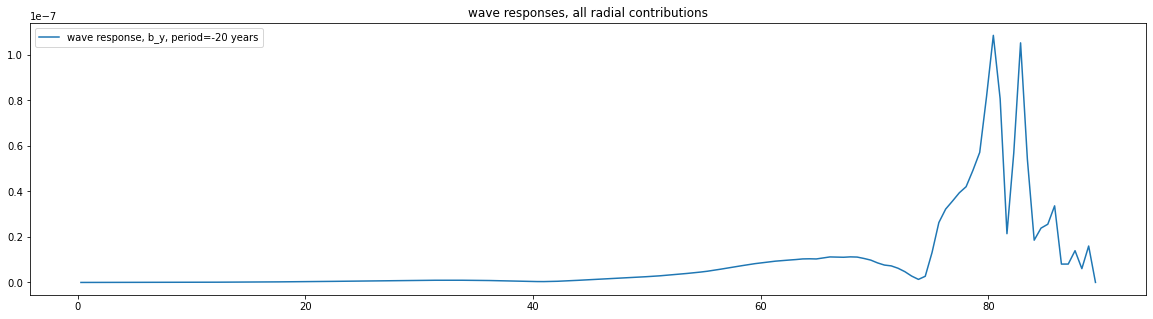

In [16]:
%%time
_,ax=plt.subplots(1,1,figsize=(20,5))
period=-20
by_all=[]
for j in range(1,58):
    _,_,by=responseBuoyancyT(150,period,j,fixedparams,temperature_y_layer_tilda_fold,spacing='cos')
    by_all.append(by)
    
by_all=np.array(by_all)
by_rms=np.sqrt((np.real(by_all)**2).sum(axis=0))#*np.sqrt(1e4*4*np.pi*1e-7)*Omega*L*(2*np.pi/20)**2*1e6

ax.plot(np.arcsin(y)*180.0/np.pi,by_rms,label='wave response, b_y, period=%i years'%period)
    
#ax.set_yscale('log')
ax.legend()
ax.set_title('wave responses, all radial contributions')

In [17]:
L = 3.48e6*0.65
Omega = 2*np.pi/86400
velocityscale = Omega*L

b_to_v_factor = -1j*omegaprime*chi*Hprime/Brprime

vy_all = velocityscale*b_to_v_factor*by_all # in m/s
vy_rms=np.sqrt((np.real(vy_all)**2).sum(axis=0))

Text(0.5, 1.0, 'wave velocity perturbation rms, all radial contributions')

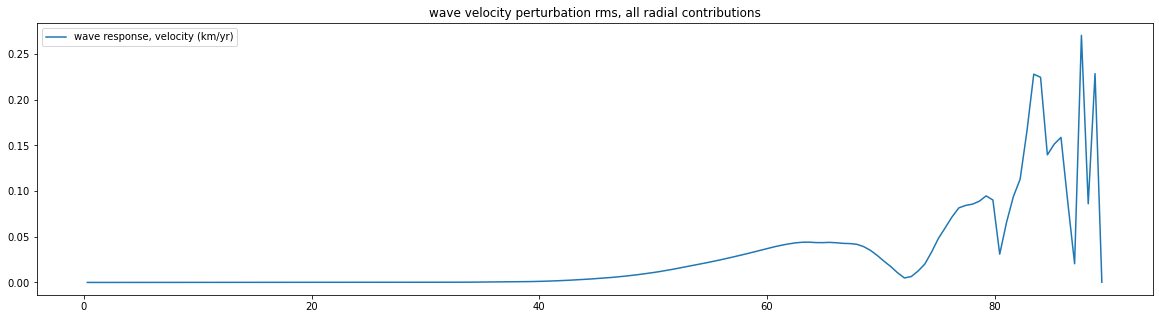

In [18]:
_,ax=plt.subplots(1,1,figsize=(20,5))
ax.plot(np.arcsin(y)*180.0/np.pi,vy_rms/1e3*sectoyear,label='wave response, velocity (km/yr)')
ax.legend()
ax.set_title('wave velocity perturbation rms, all radial contributions')

### Power spectrum

In [19]:
def spectrumBuoyancyT(ngrid,j,eigenmode_number,fixedparams,temperature_tilda,spacing='linear',npoints=7):
    """For a given m,j(radial wavenumber), return the power spectrum of the wave response to forcing by buoyancy, projected on a specific eigenmode"""
    
    # Set up prefactor
    m,E,Pm,Rastar,Omega,Hprime,Nprime,Brprime=fixedparams
    sectoyear = 365.25 * 24 * 60 * 60
    
    kprime = np.pi*j/Hprime
    omegaprime = 2*np.pi / ((-20)*sectoyear) / Omega #assumed period for damping
    
    C0 = 2/0.65**2*kprime**2/Nprime**2
    C = C0*omegaprime
    
    chi = 1 +1j*kprime**2/omegaprime*E/Pm
    M = 1/(0.65**2)*Brprime**2*kprime**4/(chi*Nprime**2)
    
    G_r = (Rastar * Brprime * kprime**2)/ (0.65*chi*Nprime**2)
    
    # Compute matrix and eigendecomposition
    y,A=setyA(ngrid,m,M,spacing)
    wi,zi,xi=spl.eig(A,left=True)
    #Normalize left eigenvectors so that zj^H * xi = delta_ij
    zi = zi/np.diagonal(np.dot(zi.transpose().conj(),xi))[None,:].conj()
    #Sort eigenvectors by increasing period
    zi=zi[:,np.argsort(np.real(1/wi))]
    wi=wi[np.argsort(np.real(1/wi))]
    
    eigenmode_period = np.real(2*np.pi*C0/(wi[eigenmode_number]*sectoyear*Omega))
    #print("Eigenmode period=%.1f years; frequency=%.3f cycles/year"%(eigenmode_period,1/eigenmode_period))

    frequencies=np.fft.fftfreq(len(temperature_tilda),ntsteps_to_years(25))[1:]
    Cs=C0*(2*np.pi*frequencies/sectoyear / Omega)
    #Compute component of forced wave on first eigenvector
    power_spectrum=[]
    for i,C1 in enumerate(Cs):
        Fr = G_r*temperature_tilda[i,j-1,:]
        rhs=rhsForcing(y,C1,m,M,Fr,0.,0.,spacing,npoints)
        c_forcing = np.dot(zi[:,eigenmode_number].conj(),rhs)
        power=np.abs((c_forcing/(wi[eigenmode_number]-C1)))**2
        power_spectrum.append(power)
    power_spectrum=np.array(power_spectrum)[np.argsort(frequencies)]
    return np.sort(frequencies),power_spectrum,eigenmode_period

0123456789

Text(0.5, 1.0, '$|c_k(\\omega)/(\\omega_k-\\omega)|^2$ - buoyancy force')

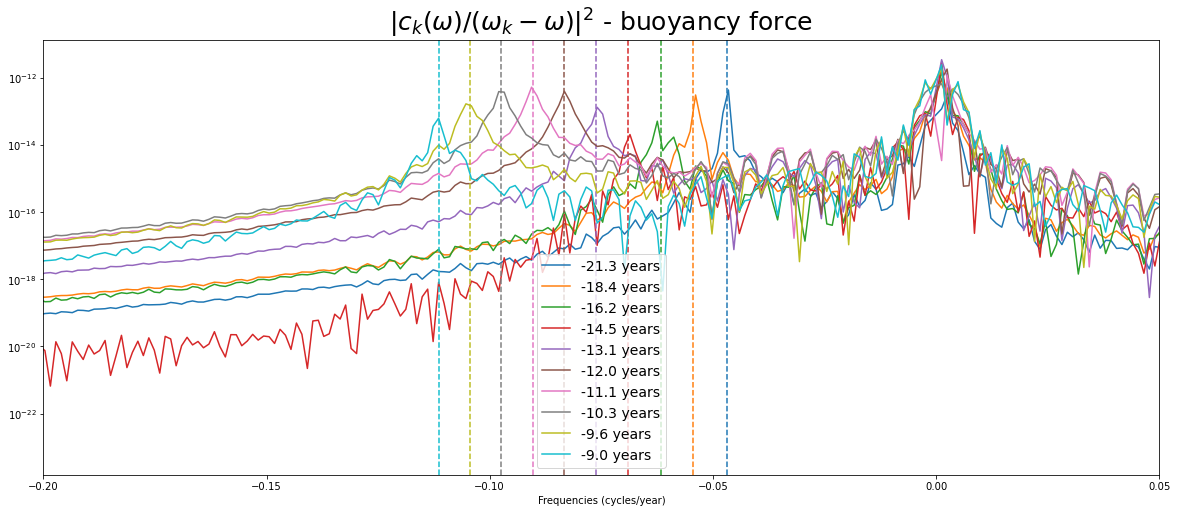

In [20]:
_,ax=plt.subplots(1,1,figsize=(20,8))
colors=plt.rcParams['axes.prop_cycle'].by_key()['color']
for i in range(10):
    print(i,end='')
    frequencies,power_spectrum,period=spectrumBuoyancyT(150,1,i,fixedparams,temperature_y_layer_tilda_fold,spacing='cos')
    ax.plot(frequencies,power_spectrum,color=colors[i%10],label="%.1f years"%period)
    ax.axvline(1/period,color=colors[i%10],linestyle='--')
    
ax.set_xlim(-0.2,0.05) 
ax.legend(fontsize=14)
ax.set_xlabel('Frequencies (cycles/year)')
ax.set_yscale('log')
ax.set_title(r'$|c_k(\omega)/(\omega_k-\omega)|^2$ - buoyancy force',fontsize=25)

0123456789

Text(0.5, 1.0, '$\\omega^2|c_k(\\omega)/(\\omega_k-\\omega)|^2$ - buoyancy force')

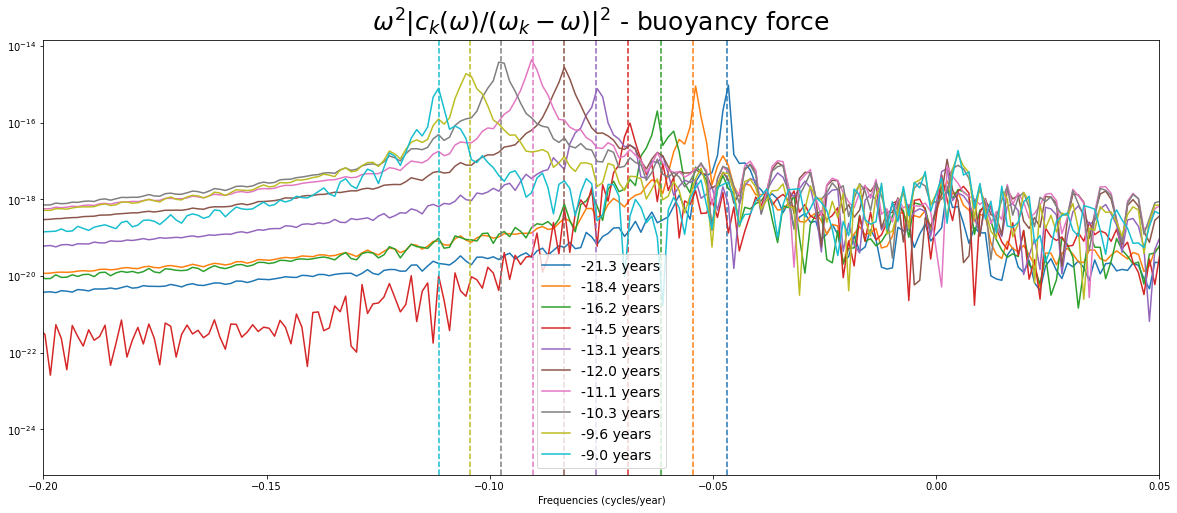

In [21]:
_,ax=plt.subplots(1,1,figsize=(20,8))
colors=plt.rcParams['axes.prop_cycle'].by_key()['color']
for i in range(10):
    print(i,end='')
    frequencies,power_spectrum,period=spectrumBuoyancyT(150,1,i,fixedparams,temperature_y_layer_tilda_fold,spacing='cos')
    ax.plot(frequencies,frequencies**2*power_spectrum,color=colors[i%10],label="%.1f years"%period)
    ax.axvline(1/period,color=colors[i%10],linestyle='--')
    
ax.set_xlim(-0.2,0.05) 
ax.legend(fontsize=14)
ax.set_xlabel('Frequencies (cycles/year)')
ax.set_yscale('log')
ax.set_title(r'$\omega^2|c_k(\omega)/(\omega_k-\omega)|^2$ - buoyancy force',fontsize=25)

# Lorentz source

In [36]:
# Fourier transform the forcing
y,_=setyA(150,m,M,'cos')
lorentz_theta_y_layer_tilda_300=transformForcing(lorentz_theta_y,'cos')
lorentz_phi_y_layer_tilda_300=transformForcing(lorentz_phi_y,'cos')
lorentz_r_y_layer_tilda_300=transformForcing(lorentz_r_y,'cos')

In [37]:
# Average NH and SH (i.e. fold it). At this time it's still in Calypso scales
lorentz_theta_y_layer_tilda_fold=0.5*(lorentz_theta_y_layer_tilda_300[:,:,150:]+lorentz_theta_y_layer_tilda_300[:,:,149::-1])
lorentz_phi_y_layer_tilda_fold=0.5*(lorentz_phi_y_layer_tilda_300[:,:,150:]+lorentz_phi_y_layer_tilda_300[:,:,149::-1])
lorentz_r_y_layer_tilda_fold=0.5*(lorentz_r_y_layer_tilda_300[:,:,150:]+lorentz_r_y_layer_tilda_300[:,:,149::-1])

In [38]:
# Convert magnitude to diffusion-free scales
E_sim=1e-5;Pm_sim=0.5
lorentz_theta_y_layer_tilda_fold *= E_sim**2
lorentz_phi_y_layer_tilda_fold *= E_sim**2
lorentz_r_y_layer_tilda_fold *= E_sim**2

## Response to a fixed frequency

In [25]:
def responseLorentz(ngrid,period,j,fixedparams,lorentz_r_tilda,lorentz_theta_tilda,lorentz_phi_tilda,spacing='linear',npoints=7):
    """For a given m,j(radial wavenumber), and wave period, return the latitudinal shape of the wave response to forcing by buoyancy"""
    m,E,Pm,Rastar,Omega,Hprime,Nprime,Brprime=fixedparams
    sectoyear = 365.25 * 24 * 60 * 60
    
    kprime = np.pi*j/Hprime
    omegaprime = 2*np.pi / (period*sectoyear) / Omega #assumed period for damping
    
    C0 = 2/0.65**2*kprime**2/Nprime**2
    C = C0*omegaprime
    
    chi = 1 +1j*kprime**2/omegaprime*E/Pm
    M = 1/(0.65**2)*Brprime**2*kprime**4/(chi*Nprime**2)

    G_h = (Brprime * kprime**3)/ (0.65**2*chi*Nprime**2)
    G_r = G_h*0.65/kprime
    
    #Find the index corresponding to the desired frequency
    if period >0:
        freq_idx=int(800*25/years_to_ntsteps(period))
    else:
        freq_idx=800-int(800*25/years_to_ntsteps(-period))
        
    Fr     = G_r*lorentz_r_tilda[freq_idx,j-1,:]
    Ftheta = G_h*lorentz_theta_tilda[freq_idx,j-1,:]
    Fphi   = G_h*lorentz_phi_tilda[freq_idx,j-1,:]
    
    y,A =setyA(ngrid,m,M,'cos')
    rhs,by= responseForcing(y,A,C,m,M,Fr,Ftheta,Fphi,spacing=spacing,npoints=npoints)
    
    return (Fr,Ftheta,Fphi),rhs[ngrid:],by


Text(0.5, 1.0, 'rhs')

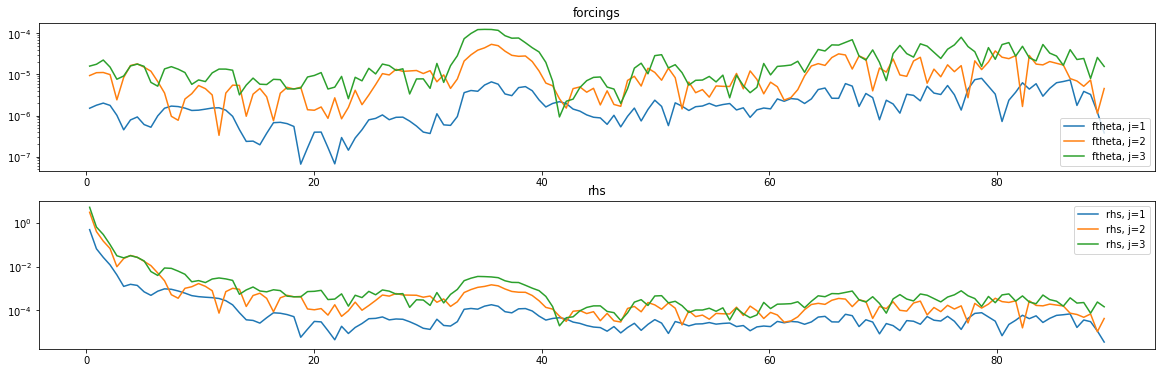

In [26]:
_,ax=plt.subplots(2,1,figsize=(20,6))
fixedparams=(m,E,Pm,Rastar,Omega,Hprime,Nprime,Brprime)

zero=0.*lorentz_theta_y_layer_tilda_fold

cutoff=0
for j in range(1,4):
    forcings,rhs,by=responseLorentz(150,-20,j,fixedparams,zero,lorentz_theta_y_layer_tilda_fold,zero,spacing='cos')
    ax[0].plot(np.arcsin(y)*180.0/np.pi,np.abs(forcings[1]),label='ftheta, j=%i'%j)
    ax[1].plot(np.arcsin(y)*180.0/np.pi,np.abs(rhs),label='rhs, j=%i'%j)

for i,a in enumerate(ax):
    if  i < 2:
        a.set_yscale('log')
    a.legend()
ax[0].set_title('forcings')
ax[1].set_title('rhs')


Text(0.5, 1.0, 'wave responses, linear scale')

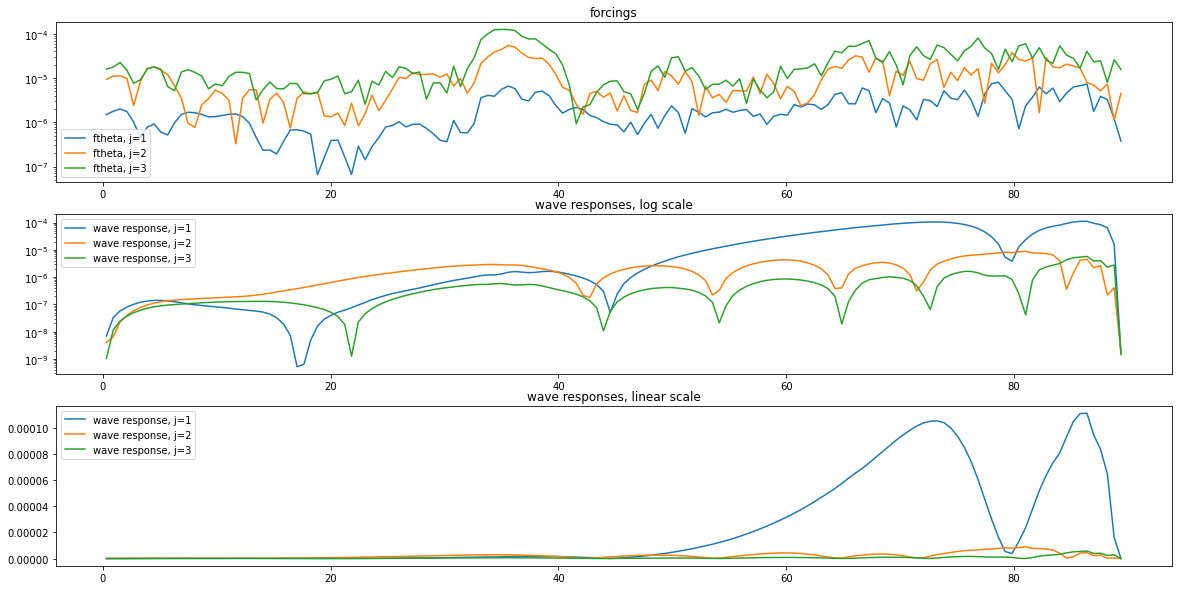

In [27]:
_,ax=plt.subplots(3,1,figsize=(20,10))
fixedparams=(m,E,Pm,Rastar,Omega,Hprime,Nprime,Brprime)

zero=0.*lorentz_theta_y_layer_tilda_fold

cutoff=0
for j in range(1,4):
    forcings,rhs,by=responseLorentz(150,-20,j,fixedparams,zero,lorentz_theta_y_layer_tilda_fold,zero,spacing='cos')
    ax[0].plot(np.arcsin(y)*180.0/np.pi,np.abs(forcings[1]),label='ftheta, j=%i'%j)
    ax[1].plot(np.arcsin(y[cutoff:])*180.0/np.pi,np.abs(np.real(by))[cutoff:],label='wave response, j=%i'%j)
    ax[2].plot(np.arcsin(y[cutoff:])*180.0/np.pi,np.abs(np.real(by))[cutoff:],label='wave response, j=%i'%j)

for i,a in enumerate(ax):
    if  i < 2:
        a.set_yscale('log')
    a.legend()
ax[0].set_title('forcings')
ax[1].set_title('wave responses, log scale')
ax[2].set_title('wave responses, linear scale')

CPU times: user 872 ms, sys: 27.4 ms, total: 899 ms
Wall time: 763 ms


Text(0.5, 1.0, 'wave velocity perturbation rms, all radial contributions')

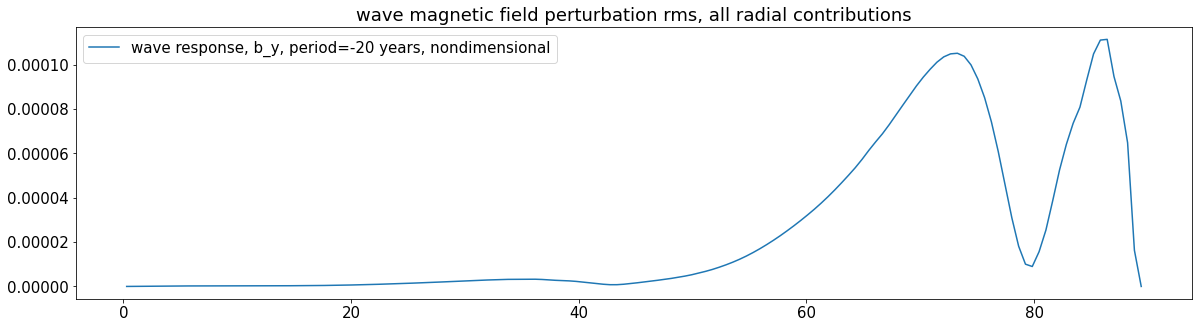

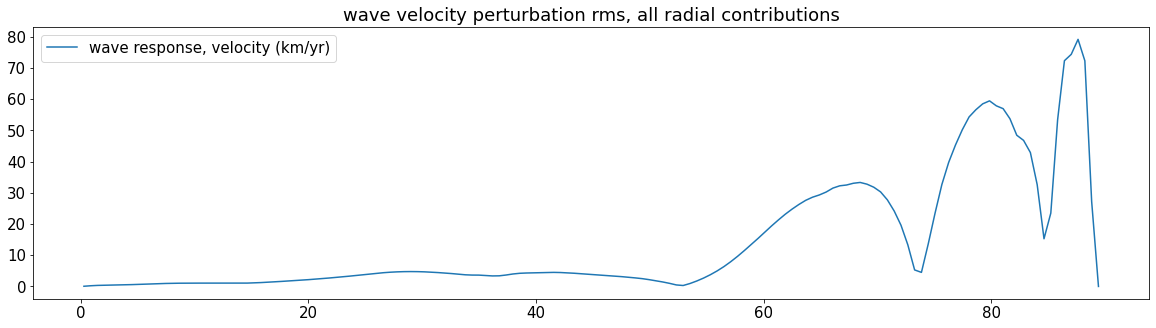

In [28]:
%%time
plt.rcParams.update({'font.size': 15})
_,ax=plt.subplots(1,1,figsize=(20,5))
period=-20
by_all=[]
for j in range(1,58):
    _,_,by=responseLorentz(150,period,j,fixedparams,zero,lorentz_theta_y_layer_tilda_fold,zero,spacing='cos')
    by_all.append(by)
    
by_all=np.array(by_all)
by_rms=np.sqrt((np.real(by_all)**2).sum(axis=0))

ax.plot(np.arcsin(y)*180.0/np.pi,by_rms,label='wave response, b_y, period=%i years, nondimensional'%period)
    
#ax.set_yscale('log')
ax.legend()
ax.set_title('wave magnetic field perturbation rms, all radial contributions')

vy_all = velocityscale*b_to_v_factor*by_all # in m/s
vy_rms=np.sqrt((np.real(vy_all)**2).sum(axis=0))
_,ax=plt.subplots(1,1,figsize=(20,5))
ax.plot(np.arcsin(y)*180.0/np.pi,vy_rms/1e3*sectoyear,label='wave response, velocity (km/yr)')
ax.legend()
ax.set_title('wave velocity perturbation rms, all radial contributions')

In comparison Knezek&Buffett found 0.075m/s = 2000km/yr

## Power spectrum on eigenmodes

In [30]:
def spectrumLorentz(ngrid,j,eigenmode_number,fixedparams,lorentz_r_tilda,lorentz_theta_tilda,lorentz_phi_tilda,spacing='linear',npoints=7):
    """For a given m,j(radial wavenumber), return the power spectrum of the wave response to forcing by the Lorentz force, projected on a specific eigenmode"""
    
    # Set up prefactor
    m,E,Pm,Rastar,Omega,Hprime,Nprime,Brprime=fixedparams
    sectoyear = 365.25 * 24 * 60 * 60
    
    kprime = np.pi*j/Hprime
    omegaprime = 2*np.pi / ((-20)*sectoyear) / Omega
    
    C0 = 2/0.65**2*kprime**2/Nprime**2
    C = C0*omegaprime
    
    chi = 1 +1j*kprime**2/omegaprime*E/Pm
    M = 1/(0.65**2)*Brprime**2*kprime**4/(chi*Nprime**2)

    G_h = (Brprime * kprime**3)/ (0.65**2*chi*Nprime**2)
    G_r = G_h*0.65/kprime
    
    # Compute matrix and eigendecomposition
    y,A=setyA(ngrid,m,M,spacing)
    wi,zi,xi=spl.eig(A,left=True)
    #Normalize left eigenvectors so that zj^H * xi = delta_ij
    zi = zi/np.diagonal(np.dot(zi.transpose().conj(),xi))[None,:].conj()
    #Sort eigenvectors by increasing period
    zi=zi[:,np.argsort(np.real(1/wi))]
    wi=wi[np.argsort(np.real(1/wi))]
    
    eigenmode_period = np.real(2*np.pi*C0/(wi[eigenmode_number]*sectoyear*Omega))

    frequencies=np.fft.fftfreq(len(lorentz_theta_tilda),ntsteps_to_years(25))[1:]
    Cs=C0*(2*np.pi*frequencies/sectoyear / Omega)
    
    #Compute component of forced wave on first eigenvector
    power_spectrum=[]
    for i,C1 in enumerate(Cs):
        Fr     = G_r*lorentz_r_tilda[i,j-1,:]
        Ftheta = G_h*lorentz_theta_tilda[i,j-1,:]
        Fphi   = G_h*lorentz_phi_tilda[i,j-1,:]
        rhs=rhsForcing(y,C1,m,M,Fr,Ftheta,Fphi,spacing,npoints)
        #rhs=np.concatenate([np.zeros(ngrid),Ftheta])  
        c_forcing = np.dot(zi[:,eigenmode_number].conj(),rhs)
        #power=np.abs(c_forcing)**2
        power=np.abs((c_forcing/(wi[eigenmode_number]-C1)))**2

        power_spectrum.append(power)
    power_spectrum=np.array(power_spectrum)[np.argsort(frequencies)]
    return np.sort(frequencies),power_spectrum,eigenmode_period

We are solving the eigenvalue problem: $Ax - \omega x = 0$. Denote its eigenvalues, left and right eivenvectors by $(\omega_k)_{1\leq k \leq N},(z_k)_{1\leq k \leq N},(x_k)_{1\leq k \leq N}$. 

We pick one $k$, identified by its period $T_k = 2\pi/\omega_k$. We write the forcing (or rather its partial fourier transform) as $F(\omega,y)$, and we denote $x(\omega,y)$ the response to the forced problem $Ax(\omega,y) - \omega x(\omega,y) = F(\omega,y)$.

We plot below, for various $k$, the function $\omega \mapsto |x_k(y)^Tx(\omega,y)|^2$.

To obtain this quantity, we express $F$ as $F(\omega,y)=\sum_k c_k(\omega) x_k(y)$. $x$ is then given by $x(\omega,y)=\sum_k \dfrac{c_k(\omega)}{\omega_k-\omega} x_k(y)$


0 1 2 3 4 

Text(0.5, 1.0, '$|c_k(\\omega)/(\\omega_k-\\omega)|^2$')

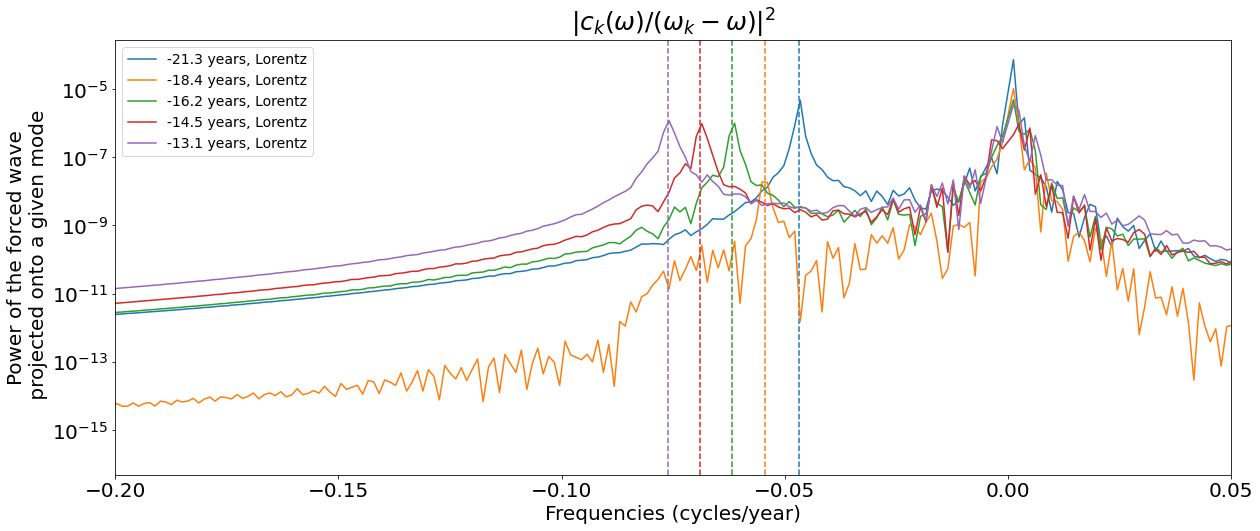

In [32]:
matplotlib.rcParams.update({'font.size': 20})
_,ax=plt.subplots(1,1,figsize=(20,8))
colors=plt.rcParams['axes.prop_cycle'].by_key()['color']
for i in range(5):
    print(i,end=' ')
    frequencies,power_spectrum,period=spectrumLorentz(150,1,i,fixedparams,zero,lorentz_theta_y_layer_tilda_fold,zero,spacing='cos')
    ax.plot(frequencies,power_spectrum,color=colors[i%10],label="%.1f years, Lorentz"%period)
    ax.axvline(1/period,color=colors[i%10],linestyle='--')
    
ax.set_xlim(-0.2,0.05) 
ax.legend(fontsize=14,loc=2)
ax.set_xlabel('Frequencies (cycles/year)')
ax.set_ylabel('Power of the forced wave\n projected onto a given mode')
ax.set_yscale('log')
ax.set_title(r'$|c_k(\omega)/(\omega_k-\omega)|^2$',fontsize=25)

#ax.set_ylim(0.,0.005)

0 1 2 3 4 5 6 7 8 9 

Text(0.5, 1.0, '$\\omega^2|c_k(\\omega)/(\\omega_k-\\omega)|^2$')

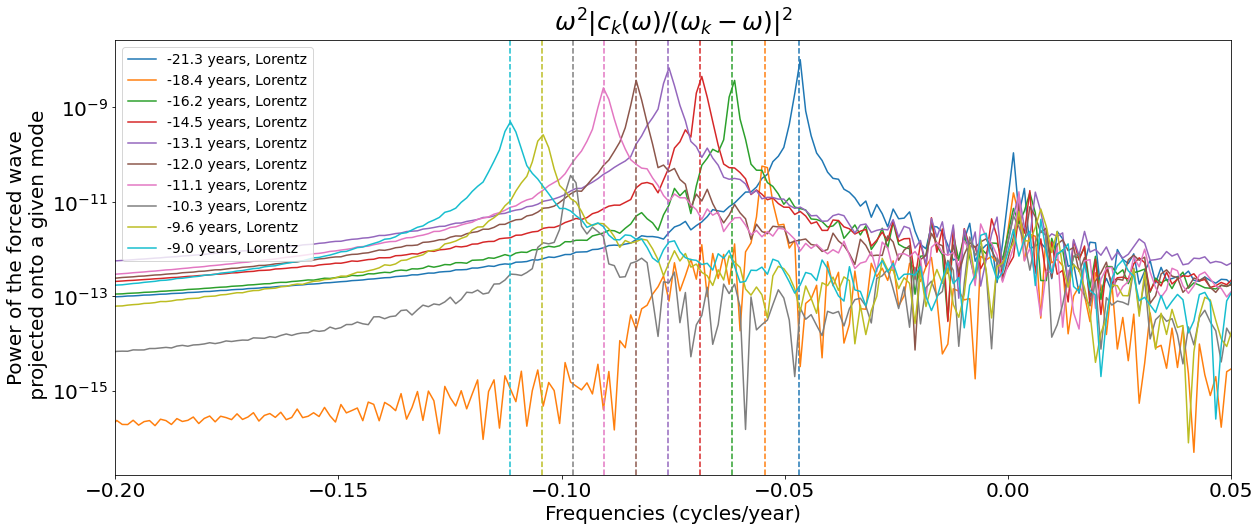

In [43]:
matplotlib.rcParams.update({'font.size': 20})
_,ax=plt.subplots(1,1,figsize=(20,8))
colors=plt.rcParams['axes.prop_cycle'].by_key()['color']
for i in range(10):
    print(i,end=' ')
    frequencies,power_spectrum,period=spectrumLorentz(150,1,i,fixedparams,zero,lorentz_theta_y_layer_tilda_fold,zero,spacing='cos')
    ax.plot(frequencies,frequencies**2*power_spectrum,color=colors[i%10],label="%.1f years, Lorentz"%period)
    ax.axvline(1/period,color=colors[i%10],linestyle='--')
    
ax.set_xlim(-0.2,0.05) 
ax.legend(fontsize=14,loc=2)
ax.set_xlabel('Frequencies (cycles/year)')
ax.set_ylabel('Power of the forced wave\n projected onto a given mode')
ax.set_yscale('log')
ax.set_title(r'$\omega^2|c_k(\omega)/(\omega_k-\omega)|^2$',fontsize=25)

#ax.set_ylim(0.,0.005)

0 1 2 

Text(0.5, 1.0, '$\\omega^2|c_k(\\omega)/(\\omega_k-\\omega)|^2$')

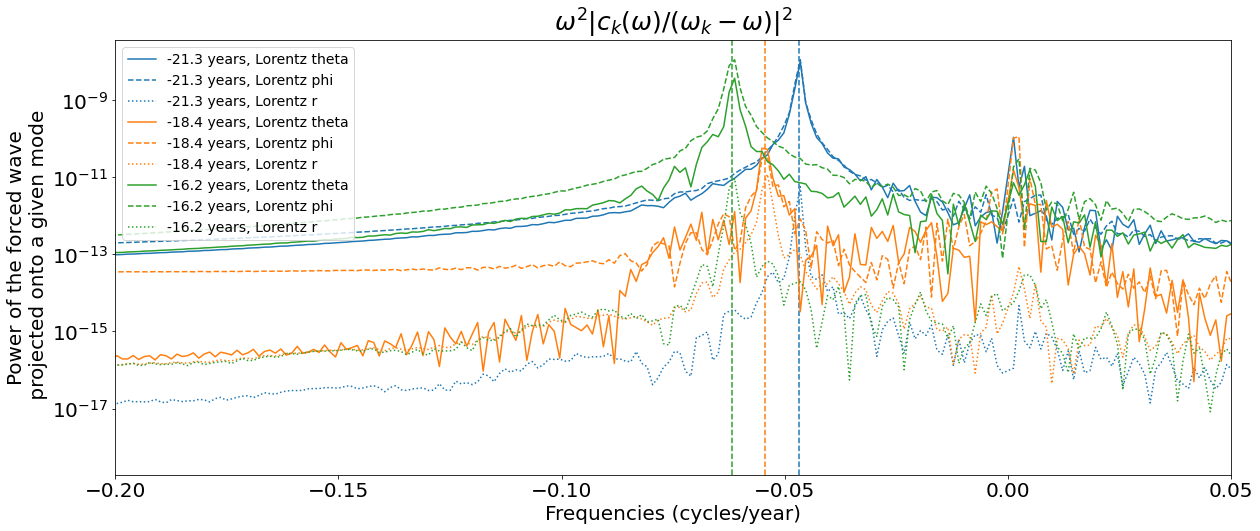

In [42]:
matplotlib.rcParams.update({'font.size': 20})
_,ax=plt.subplots(1,1,figsize=(20,8))
colors=plt.rcParams['axes.prop_cycle'].by_key()['color']
for i in range(3):
    print(i,end=' ')
    frequencies,power_spectrum,period=spectrumLorentz(150,1,i,fixedparams,zero,lorentz_theta_y_layer_tilda_fold,zero,spacing='cos')
    ax.plot(frequencies,frequencies**2*power_spectrum,color=colors[i%10],label="%.1f years, Lorentz theta"%period)
    ax.axvline(1/period,color=colors[i%10],linestyle='--')
    
    frequencies,power_spectrum,period=spectrumLorentz(150,1,i,fixedparams,zero,zero,lorentz_phi_y_layer_tilda_fold,spacing='cos')
    ax.plot(frequencies,frequencies**2*power_spectrum,color=colors[i%10],linestyle='--',label="%.1f years, Lorentz phi"%period)

    frequencies,power_spectrum,period=spectrumLorentz(150,1,i,fixedparams,lorentz_r_y_layer_tilda_fold,zero,zero,spacing='cos')
    ax.plot(frequencies,frequencies**2*power_spectrum,color=colors[i%10],linestyle=':',label="%.1f years, Lorentz r"%period)
    
    
ax.set_xlim(-0.2,0.05) 
ax.legend(fontsize=14,loc=2)
ax.set_xlabel('Frequencies (cycles/year)')
ax.set_ylabel('Power of the forced wave\n projected onto a given mode')
ax.set_yscale('log')
ax.set_title(r'$\omega^2|c_k(\omega)/(\omega_k-\omega)|^2$',fontsize=25)

#ax.set_ylim(0.,0.005)